In [ ]:
!pip install tensorflow matplotlib scikit-learn seaborn --quiet

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# ------------------------------
# Load & Preprocess Dataset
# ------------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = y_train.flatten(), y_test.flatten()
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


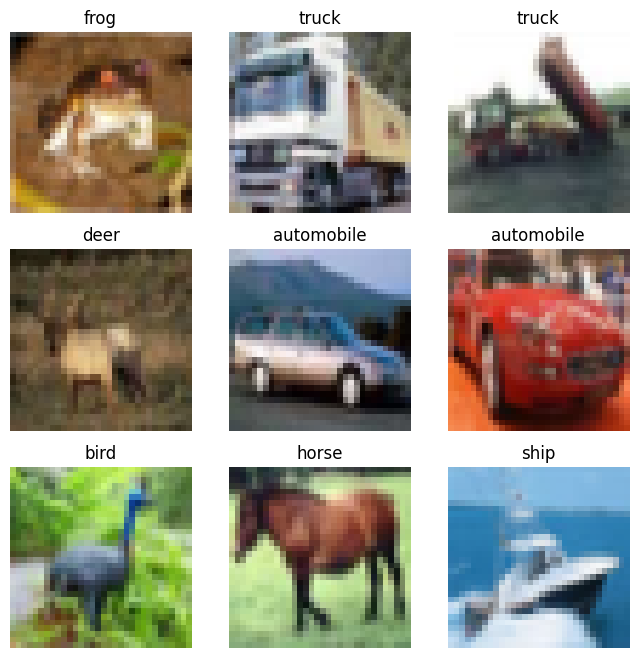

In [ ]:
# Visualize sample images
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_train[i])
    plt.title(class_names[y_train[i]])
    plt.axis('off')
plt.show()

In [ ]:
# ------------------------------
# Build & Train a Basic CNN
# ------------------------------
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))  # reduced epochs for speed

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.3403 - loss: 1.7741 - val_accuracy: 0.5584 - val_loss: 1.2269
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 77s 42ms/step - accuracy: 0.5720 - loss: 1.2093 - val_accuracy: 0.5822 - val_loss: 1.1570
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 42ms/step - accuracy: 0.6334 - loss: 1.0425 - val_accuracy: 0.6517 - val_loss: 1.0013


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 118ms/step - accuracy: 0.6053 - loss: 1.1205 - val_accuracy: 0.6400 - val_loss: 1.0290
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 110ms/step - accuracy: 0.6263 - loss: 1.0608 - val_accuracy: 0.6579 - val_loss: 0.9960
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 107ms/step - accuracy: 0.6411 - loss: 1.0184 - val_accuracy: 0.6887 - val_loss: 0.8931
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.79      0.68      0.73      1000
  automobile       0.78      0.84      0.81      1000
        bird       0.72      0.45      0.56      1000
         cat       0.53      0.44      0.48      1000
        deer       0.73      0.52      0.60      1000
         dog       0.55      0.69      0.61      1000
        frog       0.72      0.81      0.76      1000
       horse       0.65      0.80      0.72      1000
        ship       0.82      0.79      0.81      1000
 

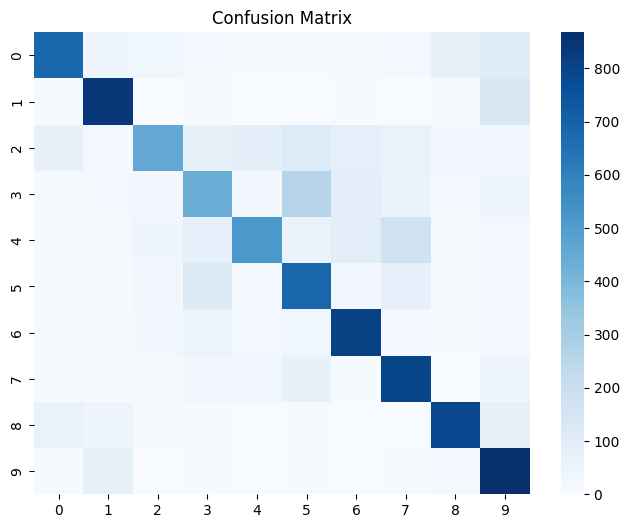

In [ ]:
# ------------------------------
# Data Augmentation & Evaluation
# ------------------------------
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1,
                             height_shift_range=0.1, horizontal_flip=True)
datagen.fit(x_train)

aug_model = tf.keras.models.clone_model(cnn_model)
aug_model.set_weights(cnn_model.get_weights())
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
aug_model.fit(datagen.flow(x_train, y_train, batch_size=64), epochs=3, validation_data=(x_test, y_test))

y_pred = aug_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# ------------------------------
# Transfer Learning with MobileNetV2
# ------------------------------
base_model = tf.keras.applications.MobileNetV2(input_shape=(96,96,3), include_top=False, weights='imagenet')
base_model.trainable = False
transfer_model = models.Sequential([
    tf.keras.layers.Resizing(96,96),  # ✅ fixed
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 377s 237ms/step - accuracy: 0.7095 - loss: 0.8514 - val_accuracy: 0.7959 - val_loss: 0.5852
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 394s 245ms/step - accuracy: 0.8068 - loss: 0.5466 - val_accuracy: 0.8003 - val_loss: 0.5683
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 438s 243ms/step - accuracy: 0.8269 - loss: 0.4914 - val_accuracy: 0.8014 - val_loss: 0.5813


In [ ]:
# ------------------------------
# Save Models
# ------------------------------
cnn_model.save("cnn_model.h5")
transfer_model.save("transfer_model.h5")
print("✅ Models saved successfully!")

✅ Models saved successfully!
